<a href="https://colab.research.google.com/github/xuwd11/deepul/blob/master/homeworks/hw4/Homework_4_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
!nvidia-smi

Sun Jun  7 17:06:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 749, done.
remote: Total 749 (delta 0), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (749/749), 114.90 MiB | 27.39 MiB/s, done.
Resolving deltas: 100% (344/344), done.
Checking out files: 100% (129/129), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16679 sha256=792a03d943ddfe439065f2ff72a977e4967678b70c78943056e07a843f486df5
  Stored in directory: /tmp/pip-ephem-wheel-cache-1lgtwhxl/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul


In [ ]:
# %tensorflow_version 1.x
from deepul.hw4_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')

# Question 1: Warmup [20pt]

In this question, we will train 2 different variants of GANs on an easy 1D dataset. 

Execute the cell below to visualize our datasets.

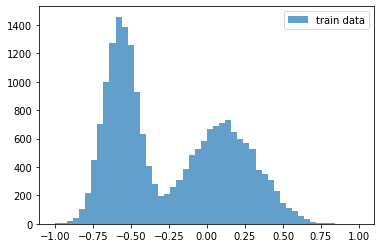

In [ ]:
visualize_q1_dataset()

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 



### Solution

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from collections import OrderedDict
from tqdm import tqdm_notebook
from torchvision.utils import save_image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_epoch(
    generator, 
    discriminator, 
    g_loss_fn, 
    d_loss_fn, 
    train_loader, 
    g_optimizer, 
    d_optimizer,
    n_critic=1,
    g_scheduler=None,
    d_scheduler=None,
    weight_clipping=None,
):
    g_losses, d_losses = [], []
    generator.train()
    discriminator.train()
    for i, x in enumerate(train_loader):
        x = x.to(device)
        d_loss = d_loss_fn(generator, discriminator, x)
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        d_losses.append(d_loss.item())
        if weight_clipping is not None:
            for param in discriminator.parameters():
                param.data.clamp_(-weight_clipping, weight_clipping)
        if i % n_critic == 0:
            g_loss = g_loss_fn(generator, discriminator, x)
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            g_losses.append(g_loss.item())
            if g_scheduler is not None:
                g_scheduler.step()
            if d_scheduler is not None:
                d_scheduler.step()
    return dict(g_losses=g_losses, d_losses=d_losses)

def get_training_snapshot(generator, discriminator, n=5000):
    generator.eval()
    discriminator.eval()
    xs = np.linspace(-1, 1, 1000)
    with torch.no_grad():
        samples = generator.sample(n).cpu().numpy()
        dis_output = discriminator(torch.FloatTensor(xs).unsqueeze(1).to(device)).cpu().numpy()
    return samples, xs, dis_output

def train(generator, discriminator, g_loss_fn, d_loss_fn, train_loader, train_args):
    n_epochs, lr = train_args["n_epochs"], train_args["lr"]
    if "optim_cls" in train_args:
        g_optimizer = train_args["optim_cls"](generator.parameters(), lr=lr)
        d_optimizer = train_args["optim_cls"](discriminator.parameters(), lr=lr)
    else:
        g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
        d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0, 0.9))
    if train_args.get("lr_schedule", None) is not None:
        g_scheduler = optim.lr_scheduler.LambdaLR(g_optimizer, train_args["lr_schedule"])
        d_scheduler = optim.lr_scheduler.LambdaLR(d_optimizer, train_args["lr_schedule"])
    else:
        g_scheduler = None
        d_scheduler = None
    train_losses = dict()
    for epoch in tqdm_notebook(range(n_epochs), desc='Epoch', leave=False):
        if epoch == 1:
            epoch1_snapshot = get_training_snapshot(generator, discriminator)
        generator.train()
        discriminator.train()
        train_loss = train_epoch(
            generator, 
            discriminator, 
            g_loss_fn, 
            d_loss_fn, 
            train_loader, 
            g_optimizer, 
            d_optimizer,
            n_critic=train_args.get("n_critic", 1),
            g_scheduler=g_scheduler,
            d_scheduler=d_scheduler,
            weight_clipping=train_args.get("weight_clipping", None),
        )
        for k, v in train_loss.items():
            if k not in train_losses:
                train_losses[k] = []
            train_losses[k].extend(train_loss[k])
    final_snapshot = get_training_snapshot(generator, discriminator)
    return [train_losses, *epoch1_snapshot, *final_snapshot]

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hiddens, hidden_size, output_size):
        super().__init__()
        model = []
        for _ in range(n_hiddens):
            model.append(nn.Linear(input_size, hidden_size))
            model.append(nn.LeakyReLU(0.2))
            input_size = hidden_size
        model.append(nn.Linear(hidden_size, output_size))
        self.net = nn.Sequential(*model)
    
    def forward(self, x):
        return self.net(x)

class MLPGenerator(nn.Module):
    def __init__(self, latent_dim, n_hiddens, hidden_size, data_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.model = MLP(latent_dim, n_hiddens, hidden_size, data_dim)
    
    def forward(self, z):
        return torch.tanh(self.model(z))

    def sample(self, n):
        z = torch.randn(n, self.latent_dim).to(device)
        return self(z)

class MLPDiscriminator(nn.Module):
    def __init__(self, latent_dim, n_hiddens, hidden_size, data_dim):
        super().__init__()
        self.model = MLP(latent_dim, n_hiddens, hidden_size, data_dim)

    def forward(self, z):
        return torch.sigmoid(self.model(z))

In [ ]:
def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """
    
    """ YOUR CODE HERE """
    train_data = train_data.astype(np.float32)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

    g = MLPGenerator(1, 3, 128, 1).to(device)
    d = MLPDiscriminator(1, 3, 128, 1).to(device)

    def g_loss_fn(generator, discriminator, x):
        x_fake = generator.sample(x.shape[0])
        return (1 - discriminator(x_fake)).log().mean()

    def d_loss_fn(generator, discriminator, x):
        x_fake = generator.sample(x.shape[0])
        return -(1 - discriminator(x_fake)).log().mean() - discriminator(x).log().mean()

    train_args = dict(n_epochs=25, lr=1e-4, n_critic=2)
    train_losses, samples1, xs1, dis1, samples2, xs2, dis2 = train(
        g, d, g_loss_fn, d_loss_fn, train_loader, train_args
    )

    return train_losses["d_losses"], samples1, xs1, dis1, samples2, xs2, dis2

### Results

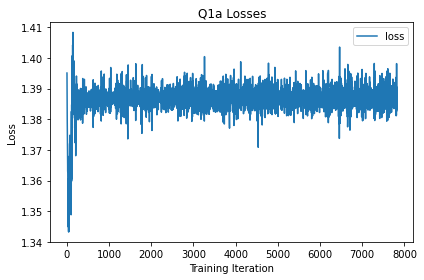

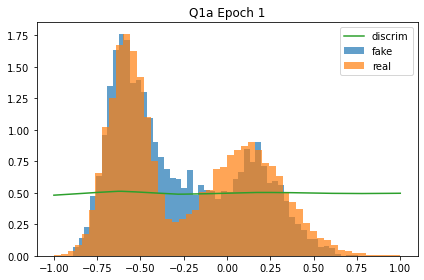

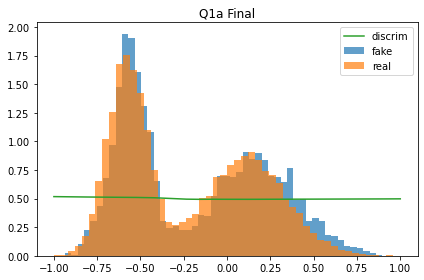

CPU times: user 59.8 s, sys: 1.11 s, total: 1min
Wall time: 1min 1s


In [ ]:
%%time

q1_save_results('a', q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate losses:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z))$$

 ### Solution

In [ ]:
def q1_b(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """
    
    """ YOUR CODE HERE """
    train_data = train_data.astype(np.float32)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

    g = MLPGenerator(1, 3, 128, 1).to(device)
    d = MLPDiscriminator(1, 3, 128, 1).to(device)

    def g_loss_fn(generator, discriminator, x):
        x_fake = generator.sample(x.shape[0])
        return - discriminator(x_fake).log().mean()

    def d_loss_fn(generator, discriminator, x):
        x_fake = generator.sample(x.shape[0])
        return -(1 - discriminator(x_fake)).log().mean() - discriminator(x).log().mean()

    train_args = dict(n_epochs=25, lr=1e-4, n_critic=2)
    train_losses, samples1, xs1, dis1, samples2, xs2, dis2 = train(
        g, d, g_loss_fn, d_loss_fn, train_loader, train_args
    )

    return train_losses["d_losses"], samples1, xs1, dis1, samples2, xs2, dis2

 ### Results

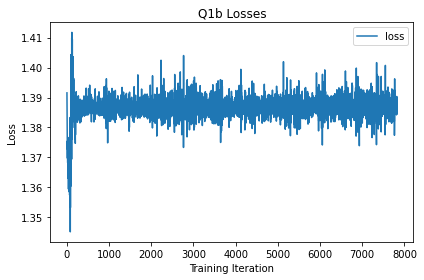

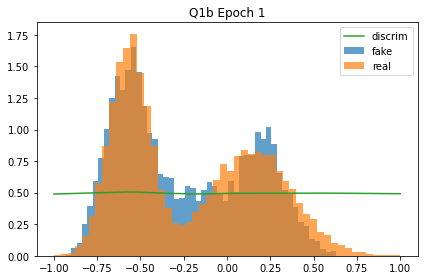

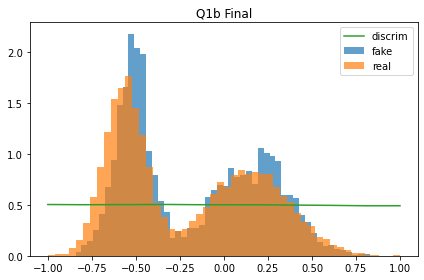

CPU times: user 59.4 s, sys: 1.13 s, total: 1min
Wall time: 1min


In [ ]:
%%time

q1_save_results('b', q1_b)

# Question 2: GANs on CIFAR-10 [35pt]

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

Files already downloaded and verified


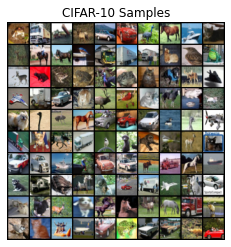

In [ ]:
visualize_q2_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Fréchet inception distance (bonus, 5pts)
3. Discriminator loss across training
4. 100 samples. 

## Solution

In [ ]:
# For debugging purpose

# train_data = load_q2_data()
# train_data = train_data.data.transpose((0, 3, 1, 2)) / 255.0
# print(train_data.shape)

In [ ]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size
 
    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(
            batch_size, s_height, s_width, s_depth
        ).permute(0, 3, 1, 2)
        return output

class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size
 
    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1).permute(0, 3, 2, 1)
        return output
 
# Spatial Upsampling with Nearest Neighbors
class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()
        self.depth_to_space = DepthToSpace(block_size=2)
        self.conv = nn.Conv2d(
            in_dim, out_dim, kernel_size, stride=stride, padding=padding, bias=bias
        )        

    def forward(self, x):
        out = torch.cat([x, x, x, x], dim=1)
        out = self.depth_to_space(out)
        out = self.conv(out)
        return out
 
# Spatial Downsampling with Spatial Mean Pooling
class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()
        self.space_to_depth = SpaceToDepth(block_size=2)
        self.conv = nn.Conv2d(
            in_dim, out_dim, kernel_size, stride=stride, padding=padding, bias=bias
        )
    
    def forward(self, x):
        out = self.space_to_depth(x)
        out = sum(out.chunk(4, dim=1)) / 4.0
        out = self.conv(out)
        return out

class ResBlockUp(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size):
        super().__init__()
        padding = kernel_size // 2
        self.net = nn.Sequential(
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=padding),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=padding),
        )
        self.res = Upsample_Conv2d(in_dim, n_filters, kernel_size=1, padding=0)

    def forward(self, x):
        return self.net(x) + self.res(x)

class ResBlockDown(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size):
        super().__init__()
        padding = kernel_size // 2
        self.net = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=padding),
            nn.ReLU(), 
            Downsample_Conv2d(n_filters, n_filters, kernel_size, padding=padding),
        )
        self.res = Downsample_Conv2d(in_dim, n_filters, kernel_size=1, padding=0)

    def forward(self, x):
        return self.net(x) + self.res(x)

class ResBlock(nn.Module):
    def __init__(self, in_dim, n_filters, kernel_size):
        super().__init__()
        padding = kernel_size // 2
        self.net = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_filters, kernel_size, padding=padding),
        )

    def forward(self, x):
        return self.net(x) + x

class Generator(nn.Module):
    def __init__(self, latent_dim, output_shape, n_filters):
        super().__init__()
        assert len(output_shape) == 3
        self.input_shape = (latent_dim * 2, output_shape[1] // 8, output_shape[2] // 8)
        self.fc = nn.Linear(latent_dim, np.prod(self.input_shape))
        self.net = nn.Sequential(
            ResBlockUp(in_dim=latent_dim * 2, n_filters=n_filters, kernel_size=3),
            ResBlockUp(in_dim=n_filters, n_filters=n_filters, kernel_size=3),
            ResBlockUp(in_dim=n_filters, n_filters=n_filters, kernel_size=3),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(n_filters, 3, kernel_size=3, padding=1),
            nn.Tanh(),
        )
        self.noise = torch.distributions.Normal(0., 1.)
        self.latent_dim = latent_dim

    def forward(self, z):
        z = self.fc(z).reshape(-1, *self.input_shape)
        return self.net(z)

    def sample(self, n):
        z = self.noise.sample([n, self.latent_dim]).to(device)
        return self(z)

class Discriminator(nn.Module):
    def __init__(self, input_shape, n_filters):
        super().__init__()
        self.net = nn.Sequential(
            ResBlockDown(in_dim=input_shape[0], n_filters=n_filters, kernel_size=3),
            ResBlockDown(in_dim=n_filters, n_filters=n_filters, kernel_size=3),
            ResBlock(in_dim=n_filters, n_filters=n_filters, kernel_size=3),
            ResBlock(in_dim=n_filters, n_filters=n_filters, kernel_size=3),
            nn.ReLU(),
        )
        self.fc = nn.Linear(n_filters, 1)

    def forward(self, z):
        z = self.net(z).sum(dim=(2, 3))
        return self.fc(z)

# For debugging purpose

# g = Generator(latent_dim=128, output_shape=(3, 32, 32), n_filters=128).to(device)
# d = Discriminator(input_shape=(3, 32, 32), n_filters=128).to(device)
# with torch.no_grad():    
#     samples = g.sample(10)
#     print(d(samples))

In [ ]:
class Solver2:
    def __init__(self, train_data, n_iters, batch_size, n_filters):
        self.n_critic = 5
        self.batch_size = batch_size
        self.n_filters = n_filters
        train_data = train_data.astype(np.float32)
        self.input_shape = tuple(train_data.shape[1:])
        self.train_loader = torch.utils.data.DataLoader(
            train_data, batch_size=batch_size, shuffle=True
        )
        self.n_epochs = self.n_critic * n_iters // len(self.train_loader)
        self.curr_iter = 0
        
    def build(self, part_name):
        self.g = Generator(
            latent_dim=128, output_shape=self.input_shape, n_filters=self.n_filters
        ).to(device)
        self.d = Discriminator(
            input_shape=self.input_shape, n_filters=self.n_filters
        ).to(device)
        self.g_optimizer = optim.Adam(self.g.parameters(), lr=2e-5, betas=(0, 0.9))
        self.g_scheduler = optim.lr_scheduler.LambdaLR(
            self.g_optimizer, lambda epoch: (self.n_epochs - epoch) / self.n_epochs
        )
        self.d_optimizer = optim.Adam(self.d.parameters(), lr=2e-5, betas=(0, 0.9))
        self.d_scheduler = optim.lr_scheduler.LambdaLR(
            self.d_optimizer, lambda epoch: (self.n_epochs - epoch) / self.n_epochs
        )
        self.part_name = part_name

    def gradient_penalty(self, x_real, x_fake):
        batch_size = x_real.shape[0]

        eps = torch.rand(batch_size, 1, 1, 1).to(device)
        x_interp = eps * x_real.data + (1 - eps) * x_fake.data
        x_interp.requires_grad = True

        d_out = self.d(x_interp)
        grad = torch.autograd.grad(
            outputs=d_out, 
            inputs=x_interp, 
            grad_outputs=torch.ones(d_out.size()).to(device),
            create_graph=True,
            retain_graph=True
        )[0]
        grad = grad.reshape(batch_size, -1)
        grad_norm = torch.sqrt(torch.sum(grad ** 2, dim=1) + 1e-12)
        return ((grad_norm - 1) ** 2).mean()

    def train(self):
        train_losses = []
        t0 = time.time()
        for epoch_i in tqdm_notebook(range(self.n_epochs), desc='Epoch', leave=False):
            epoch_i += 1
            self.d.train()
            self.g.train()
            batch_losses = []
            for batch_i, x in enumerate(
                tqdm_notebook(self.train_loader, desc='Batch', leave=False)
            ):
                batch_i += 1
                self.curr_iter += 1
                x = 2 * (x - 0.5)
                x = torch.FloatTensor(x).to(device)
                self.d_optimizer.zero_grad()
                x_fake = self.g.sample(x.shape[0])
                gp = self.gradient_penalty(x, x_fake)
                d_loss = self.d(x_fake).mean() - self.d(x).mean() + 10 * gp
                d_loss.backward()
                self.d_optimizer.step()
                if self.curr_iter % self.n_critic == 0:
                    self.g_optimizer.zero_grad()
                    x_fake = self.g.sample(self.batch_size)
                    g_loss = -self.d(x_fake).mean()
                    g_loss.backward()
                    self.g_optimizer.step()

                    # self.g_scheduler.step()
                    # self.d_scheduler.step()

                batch_losses.append(d_loss.data.cpu().numpy())
            epoch_loss = np.mean(batch_losses)
            train_losses.extend(batch_losses)
            np.save(f"{self.part_name}_train_losses.npy", np.array(train_losses))
            t = (time.time() - t0) / 60
            print(f"Epoch {epoch_i}, loss {epoch_loss:.4f}, time elapsed {t:.3f} min")
        train_losses = np.array(train_losses)
        self.save_model(f"{self.part_name}.pt")
        return train_losses

    def save_model(self, filename):
        torch.save(self.g.state_dict(), "g_" + filename)
        torch.save(self.d.state_dict(), "d_" + filename)

    def load_model(self, filename):
        self.g.load_state_dict(torch.load("g_" + filename))
        self.d.load_state_dict(torch.load("d_" + filename))

# For debugging purpose

# solver = Solver2(train_data, n_iters=80, batch_size=256, n_filters=128)
# solver.build("q2")
# solver.train()

In [ ]:
def q2(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    """ YOUR CODE HERE """
    solver = Solver2(train_data, n_iters=500, batch_size=256, n_filters=128)
    solver.build("q2")
    losses = solver.train()    
    solver.g.eval()
    solver.d.eval()
    with torch.no_grad():
        samples = solver.g.sample(1000).permute(0, 2, 3, 1).cpu().numpy() * 0.5 + 0.5
    return losses, samples

## Results

Files already downloaded and verified


Epoch 1, loss -15.9614, time elapsed 3.339 min


Epoch 2, loss -9.5141, time elapsed 6.761 min


Epoch 3, loss -7.4642, time elapsed 10.187 min


Epoch 4, loss -6.6975, time elapsed 13.615 min


Epoch 5, loss -6.4151, time elapsed 17.051 min


Epoch 6, loss -5.4834, time elapsed 20.480 min


Epoch 7, loss -5.0061, time elapsed 23.910 min


Epoch 8, loss -4.2891, time elapsed 27.337 min


Epoch 9, loss -3.9325, time elapsed 30.766 min


Epoch 10, loss -3.6283, time elapsed 34.202 min


Epoch 11, loss -3.4499, time elapsed 37.630 min


Epoch 12, loss -3.3080, time elapsed 41.060 min
..........Inception score: 2.9441557


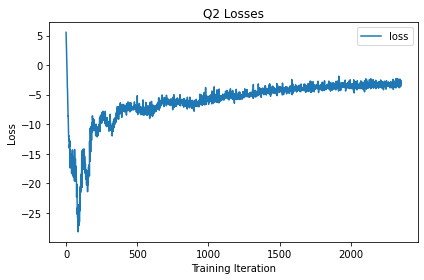

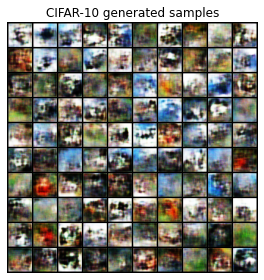

CPU times: user 25min 20s, sys: 16min 50s, total: 42min 11s
Wall time: 42min 17s


In [ ]:
%%time

q2_save_results(q2)

# Question 3: Representation Learning with BiGAN on MNIST [45pt]

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


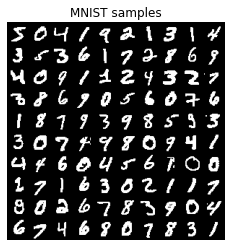

In [ ]:
visualize_q3_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


## Solution

In [ ]:
# For debugging purpose

# train_data, test_data = load_q3_data()
# print(train_data.data.shape, test_data.data.shape)

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, x_shape):
        super().__init__()
        self.x_shape = x_shape
        self.net = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.ReLU(),
            nn.Linear(1024, np.prod(x_shape)),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.net(z).reshape(z.shape[0], *self.x_shape)

class Discriminator(nn.Module):
    def __init__(self, z_dim, x_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + x_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

    def forward(self, z, x):
        return self.net(torch.cat((z, x.view(x.shape[0], -1)), dim=1))

class Encoder(nn.Module):
    def __init__(self, z_dim, x_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(x_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024, affine=False),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, z_dim),
        )

    def forward(self, x):
        return self.net(x.view(x.shape[0], -1))

# For debugging purpose

# g = Generator(z_dim=50, x_shape=(1, 28, 28)).to(device)
# d = Discriminator(z_dim=50, x_dim=784).to(device)
# e = Encoder(z_dim=50, x_dim=784).to(device)
# with torch.no_grad():
#     z = torch.rand(5, 50).to(device)
#     x = g(z)
#     print(x.shape)
#     z1 = e(x)
#     print(z1.shape)
#     print(d(z1, x))

In [ ]:
class Solver3:
    def __init__(self, train_data, test_data, n_epochs, batch_size, latent_dim):
        self.batch_size = batch_size
        self.train_loader, self.test_loader = self.create_loaders(train_data, test_data)
        self.x_shape = (1, *train_data.data.shape[1:])
        self.n_epochs = n_epochs
        self.curr_iter = 0
        self.latent_dim = latent_dim
        self.part_name = "q3"
    
    def create_loaders(self, train_data, test_data):
        train_loader = torch.utils.data.DataLoader(
            train_data, batch_size=self.batch_size, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(
            test_data, batch_size=self.batch_size, shuffle=False
        )
        return train_loader, test_loader

    def build(self):
        x_dim = np.prod(self.x_shape)
        self.g = Generator(z_dim=self.latent_dim, x_shape=self.x_shape).to(device)
        self.d = Discriminator(z_dim=self.latent_dim, x_dim=x_dim).to(device)
        self.e = Encoder(z_dim=self.latent_dim, x_dim=x_dim).to(device)
        self.g_optimizer = optim.Adam(
            list(self.e.parameters()) + list(self.g.parameters()), 
            lr=2e-4, 
            betas=(0.5, 0.999), 
            weight_decay=2.5e-5,
        )
        self.g_scheduler = optim.lr_scheduler.LambdaLR(
            self.g_optimizer, lambda epoch: (self.n_epochs - epoch) / self.n_epochs
        )
        self.d_optimizer = optim.Adam(self.d.parameters(), lr=2e-4, betas=(0, 0.9))
        self.d_scheduler = optim.lr_scheduler.LambdaLR(
            self.d_optimizer, lambda epoch: (self.n_epochs - epoch) / self.n_epochs
        )
        self.reset_linear()

    def reset_linear(self):
        self.linear = nn.Linear(self.latent_dim, 10).to(device)
        self.linear_optimizer = optim.Adam(self.linear.parameters(), lr=1e-3)
        
    def get_d_loss(self, x):
        z = self.e(x)
        z_fake = torch.randn(x.shape[0], self.latent_dim).to(device)
        x_fake = self.g(z_fake)
        d_loss = - 0.5 * self.d(z, x).log().mean() \
            - 0.5 * (1 - self.d(z_fake, x_fake)).log().mean()
        return d_loss

    def train_bigan(self):
        t0 = time.time()
        train_losses = []
        for epoch_i in tqdm_notebook(range(self.n_epochs), desc='Epoch', leave=False):
            epoch_i += 1
            self.d.train()
            self.g.train()
            self.e.train()
            batch_losses = []
            for batch_i, (x, y) in enumerate(
                tqdm_notebook(self.train_loader, desc='Batch', leave=False)
            ):
                batch_i += 1
                self.curr_iter += 1
                x = x.to(device)
                
                self.d_optimizer.zero_grad()
                d_loss = self.get_d_loss(x)
                d_loss.backward()
                self.d_optimizer.step()
                
                self.g_optimizer.zero_grad()
                g_loss = -self.get_d_loss(x)
                g_loss.backward()
                self.g_optimizer.step()

                batch_losses.append(d_loss.item())

            self.d_scheduler.step()
            self.g_scheduler.step()
            epoch_loss = np.mean(batch_losses)
            train_losses.append(epoch_loss)
            t = (time.time() - t0) / 60
            print(f"Epoch {epoch_i}, loss {epoch_loss:.4f}, time elapsed {t:.3f} min")

        train_losses = np.array(train_losses)
        np.save(f"{self.part_name}_train_losses.npy", train_losses)
        self.save_models(f"{self.part_name}.pt")
        return train_losses

    def get_val_acc(self):
        self.e.eval()
        self.linear.eval()
        n_correct = 0
        n = 0
        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(device), y.to(device)
                z = self.e(x)
                logits = self.linear(z)
                y_pred = torch.argmax(logits, dim=1)
                n_correct += torch.sum(y_pred == y).float().item()
                n += x.shape[0]
        return n_correct / n

    def train_linear_classifier(self):        
        t0 = time.time()
        train_losses = []
        val_accs = []
        for epoch_i in tqdm_notebook(range(self.n_epochs // 2), desc='Epoch', leave=False):
            epoch_i += 1
            self.e.eval()
            self.linear.train()
            batch_losses = []
            for batch_i, (x, y) in enumerate(
                tqdm_notebook(self.train_loader, desc='Batch', leave=False)
            ):
                batch_i += 1
                self.curr_iter += 1
                x, y = x.to(device), y.to(device)
                
                self.linear_optimizer.zero_grad()
                z = self.e(x).detach()
                y_pred = self.linear(z)
                loss = F.cross_entropy(y_pred, y)
                loss.backward()
                self.linear_optimizer.step()

                batch_losses.append(loss.item())

            epoch_loss = np.mean(batch_losses)
            val_acc = self.get_val_acc()
            train_losses.append(epoch_loss)
            val_accs.append(val_acc)

            t = (time.time() - t0) / 60
            print(
                f"Epoch {epoch_i}, train loss {epoch_loss:.4f}, "
                + f"val acc {val_acc:.4f}, time elapsed {t:.3f} min"
            )

        train_losses = np.array(train_losses)
        np.save(f"{self.part_name}_lc_train_losses.npy", train_losses)
        train_losses, val_accs = np.array(train_losses), np.array(val_accs)
        return train_losses, val_accs

    def sample(self, n):
        self.g.eval()
        with torch.no_grad():
            z = torch.randn(n, self.latent_dim).to(device)
            samples = self.g(z)
        return samples.cpu().numpy()

    def get_recons(self, x):
        self.g.eval()
        self.e.eval()
        with torch.no_grad():
            z = self.e(x)
            x_recon = self.g(z)
        return x_recon.cpu().numpy()

    def save_models(self, filename):
        torch.save(self.g.state_dict(), "g_" + filename)
        torch.save(self.d.state_dict(), "d_" + filename)
        torch.save(self.e.state_dict(), "e_" + filename)

    def load_models(self, filename):
        self.g.load_state_dict(torch.load("g_" + filename))
        self.d.load_state_dict(torch.load("d_" + filename))
        self.e.load_state_dict(torch.load("e_" + filename))

# For debugging purpose

# solver = Solver3(train_data, test_data, n_epochs=2, batch_size=128, latent_dim=50)
# solver.build()
# solver.train_bigan()
# solver.train_linear_classifier()
# x = solver.sample(10)
# print(x.shape)
# x_recon = solver.get_recons(torch.FloatTensor(x).to(device))
# print(x_recon.shape)

In [ ]:
def q3(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    """ YOUR CODE HERE """
    solver = Solver3(train_data, test_data, n_epochs=100, batch_size=128, latent_dim=50)
    solver.build()

    print("Train linear classifier on a random encoder")
    train_losses, val_accs = solver.train_linear_classifier()

    print("Train BiGAN")
    bigan_losses = solver.train_bigan()
    samples = solver.sample(100).transpose(0, 2, 3, 1) * 0.5 + 0.5
    train_images = train_data.data[:20].unsqueeze(1) / 255.0
    train_images_tensor = (train_images * 2 - 1).to(device)
    recons = solver.get_recons(train_images_tensor) * 0.5 + 0.5
    
    print("Train linear classifier on BiGAN encoder")
    solver.reset_linear()
    bigan_train_losses, bigan_val_accs = solver.train_linear_classifier()

    print(f"Final BiGAN test linear accuracy: {bigan_val_accs[-1]}")
    print(f"Final random encoder test linear accuracy: {val_accs[-1]}")

    return bigan_losses, samples, \
        np.concatenate([train_images.numpy(), recons], axis=0).transpose(0, 2, 3, 1), \
        bigan_train_losses, train_losses

## Results

Train linear classifier on a random encoder


Epoch 1, train loss 2.1753, val acc 0.6123, time elapsed 0.181 min


Epoch 2, train loss 1.9514, val acc 0.6656, time elapsed 0.362 min


Epoch 3, train loss 1.7675, val acc 0.6820, time elapsed 0.552 min


Epoch 4, train loss 1.6166, val acc 0.7049, time elapsed 0.746 min


Epoch 5, train loss 1.4924, val acc 0.7162, time elapsed 0.937 min


Epoch 6, train loss 1.3897, val acc 0.7267, time elapsed 1.130 min


Epoch 7, train loss 1.3039, val acc 0.7329, time elapsed 1.325 min


Epoch 8, train loss 1.2315, val acc 0.7388, time elapsed 1.519 min


Epoch 9, train loss 1.1697, val acc 0.7415, time elapsed 1.711 min


Epoch 10, train loss 1.1169, val acc 0.7483, time elapsed 1.907 min


Epoch 11, train loss 1.0711, val acc 0.7526, time elapsed 2.103 min


Epoch 12, train loss 1.0314, val acc 0.7591, time elapsed 2.297 min


Epoch 13, train loss 0.9966, val acc 0.7643, time elapsed 2.488 min


Epoch 14, train loss 0.9659, val acc 0.7673, time elapsed 2.679 min


Epoch 15, train loss 0.9388, val acc 0.7713, time elapsed 2.869 min


Epoch 16, train loss 0.9147, val acc 0.7756, time elapsed 3.060 min


Epoch 17, train loss 0.8931, val acc 0.7766, time elapsed 3.251 min


Epoch 18, train loss 0.8740, val acc 0.7790, time elapsed 3.450 min


Epoch 19, train loss 0.8567, val acc 0.7823, time elapsed 3.643 min


Epoch 20, train loss 0.8411, val acc 0.7854, time elapsed 3.829 min


Epoch 21, train loss 0.8267, val acc 0.7870, time elapsed 4.014 min


Epoch 22, train loss 0.8140, val acc 0.7869, time elapsed 4.200 min


Epoch 23, train loss 0.8021, val acc 0.7903, time elapsed 4.386 min


Epoch 24, train loss 0.7914, val acc 0.7913, time elapsed 4.574 min


Epoch 25, train loss 0.7817, val acc 0.7948, time elapsed 4.760 min


Epoch 26, train loss 0.7727, val acc 0.7941, time elapsed 4.946 min


Epoch 27, train loss 0.7642, val acc 0.7955, time elapsed 5.132 min


Epoch 28, train loss 0.7565, val acc 0.7965, time elapsed 5.319 min


Epoch 29, train loss 0.7494, val acc 0.7980, time elapsed 5.505 min


Epoch 30, train loss 0.7427, val acc 0.8006, time elapsed 5.693 min


Epoch 31, train loss 0.7364, val acc 0.7991, time elapsed 5.880 min


Epoch 32, train loss 0.7306, val acc 0.8003, time elapsed 6.064 min


Epoch 33, train loss 0.7253, val acc 0.8014, time elapsed 6.253 min


Epoch 34, train loss 0.7202, val acc 0.8015, time elapsed 6.443 min


Epoch 35, train loss 0.7154, val acc 0.8042, time elapsed 6.629 min


Epoch 36, train loss 0.7110, val acc 0.8046, time elapsed 6.815 min


Epoch 37, train loss 0.7067, val acc 0.8058, time elapsed 7.002 min


Epoch 38, train loss 0.7027, val acc 0.8069, time elapsed 7.192 min


Epoch 39, train loss 0.6989, val acc 0.8072, time elapsed 7.379 min


Epoch 40, train loss 0.6954, val acc 0.8079, time elapsed 7.565 min


Epoch 41, train loss 0.6920, val acc 0.8093, time elapsed 7.752 min


Epoch 42, train loss 0.6888, val acc 0.8093, time elapsed 7.937 min


Epoch 43, train loss 0.6857, val acc 0.8100, time elapsed 8.122 min


Epoch 44, train loss 0.6828, val acc 0.8105, time elapsed 8.310 min


Epoch 45, train loss 0.6801, val acc 0.8113, time elapsed 8.503 min


Epoch 46, train loss 0.6773, val acc 0.8115, time elapsed 8.692 min


Epoch 47, train loss 0.6748, val acc 0.8118, time elapsed 8.877 min


Epoch 48, train loss 0.6724, val acc 0.8127, time elapsed 9.062 min


Epoch 49, train loss 0.6701, val acc 0.8119, time elapsed 9.246 min


Epoch 50, train loss 0.6679, val acc 0.8123, time elapsed 9.437 min
Train BiGAN


Epoch 1, loss 0.5910, time elapsed 0.274 min


Epoch 2, loss 0.5877, time elapsed 0.550 min


Epoch 3, loss 0.5667, time elapsed 0.822 min


Epoch 4, loss 0.5627, time elapsed 1.096 min


Epoch 5, loss 0.5479, time elapsed 1.369 min


Epoch 6, loss 0.5447, time elapsed 1.643 min


Epoch 7, loss 0.5399, time elapsed 1.916 min


Epoch 8, loss 0.5394, time elapsed 2.188 min


Epoch 9, loss 0.5383, time elapsed 2.458 min


Epoch 10, loss 0.5339, time elapsed 2.725 min


Epoch 11, loss 0.5358, time elapsed 2.994 min


Epoch 12, loss 0.5343, time elapsed 3.268 min


Epoch 13, loss 0.5337, time elapsed 3.539 min


Epoch 14, loss 0.5177, time elapsed 3.809 min


Epoch 15, loss 0.5294, time elapsed 4.068 min


Epoch 16, loss 0.5253, time elapsed 4.327 min


Epoch 17, loss 0.5245, time elapsed 4.580 min


Epoch 18, loss 0.5216, time elapsed 4.832 min


Epoch 19, loss 0.5221, time elapsed 5.084 min


Epoch 20, loss 0.5152, time elapsed 5.333 min


Epoch 21, loss 0.5124, time elapsed 5.584 min


Epoch 22, loss 0.5118, time elapsed 5.837 min


Epoch 23, loss 0.5116, time elapsed 6.083 min


Epoch 24, loss 0.5091, time elapsed 6.332 min


Epoch 25, loss 0.5078, time elapsed 6.582 min


Epoch 26, loss 0.5038, time elapsed 6.831 min


Epoch 27, loss 0.5047, time elapsed 7.084 min


Epoch 28, loss 0.5015, time elapsed 7.336 min


Epoch 29, loss 0.4977, time elapsed 7.584 min


Epoch 30, loss 0.4971, time elapsed 7.834 min


Epoch 31, loss 0.4968, time elapsed 8.085 min


Epoch 32, loss 0.4922, time elapsed 8.337 min


Epoch 33, loss 0.4896, time elapsed 8.590 min


Epoch 34, loss 0.4900, time elapsed 8.842 min


Epoch 35, loss 0.4858, time elapsed 9.090 min


Epoch 36, loss 0.4837, time elapsed 9.341 min


Epoch 37, loss 0.4788, time elapsed 9.597 min


Epoch 38, loss 0.4795, time elapsed 9.848 min


Epoch 39, loss 0.4760, time elapsed 10.095 min


Epoch 40, loss 0.4759, time elapsed 10.346 min


Epoch 41, loss 0.4752, time elapsed 10.595 min


Epoch 42, loss 0.4749, time elapsed 10.842 min


Epoch 43, loss 0.4726, time elapsed 11.092 min


Epoch 44, loss 0.4644, time elapsed 11.342 min


Epoch 45, loss 0.4673, time elapsed 11.590 min


Epoch 46, loss 0.4630, time elapsed 11.838 min


Epoch 47, loss 0.4604, time elapsed 12.092 min


Epoch 48, loss 0.4607, time elapsed 12.343 min


Epoch 49, loss 0.4576, time elapsed 12.599 min


Epoch 50, loss 0.4574, time elapsed 12.848 min


Epoch 51, loss 0.4531, time elapsed 13.098 min


Epoch 52, loss 0.4513, time elapsed 13.346 min


Epoch 53, loss 0.4480, time elapsed 13.597 min


Epoch 54, loss 0.4446, time elapsed 13.849 min


Epoch 55, loss 0.4463, time elapsed 14.099 min


Epoch 56, loss 0.4426, time elapsed 14.348 min


Epoch 57, loss 0.4399, time elapsed 14.601 min


Epoch 58, loss 0.4352, time elapsed 14.854 min


Epoch 59, loss 0.4348, time elapsed 15.105 min


Epoch 60, loss 0.4339, time elapsed 15.357 min


Epoch 61, loss 0.4317, time elapsed 15.607 min


Epoch 62, loss 0.4269, time elapsed 15.855 min


Epoch 63, loss 0.4271, time elapsed 16.102 min


Epoch 64, loss 0.4236, time elapsed 16.353 min


Epoch 65, loss 0.4199, time elapsed 16.602 min


Epoch 66, loss 0.4210, time elapsed 16.850 min


Epoch 67, loss 0.4165, time elapsed 17.097 min


Epoch 68, loss 0.4155, time elapsed 17.349 min


Epoch 69, loss 0.4103, time elapsed 17.598 min


Epoch 70, loss 0.4121, time elapsed 17.851 min


Epoch 71, loss 0.4070, time elapsed 18.100 min


Epoch 72, loss 0.4065, time elapsed 18.347 min


Epoch 73, loss 0.4058, time elapsed 18.595 min


Epoch 74, loss 0.4029, time elapsed 18.843 min


Epoch 75, loss 0.3981, time elapsed 19.092 min


Epoch 76, loss 0.3938, time elapsed 19.342 min


Epoch 77, loss 0.3896, time elapsed 19.588 min


Epoch 78, loss 0.3951, time elapsed 19.840 min


Epoch 79, loss 0.3891, time elapsed 20.082 min


Epoch 80, loss 0.3862, time elapsed 20.324 min


Epoch 81, loss 0.3862, time elapsed 20.575 min


Epoch 82, loss 0.3855, time elapsed 20.826 min


Epoch 83, loss 0.3800, time elapsed 21.082 min


Epoch 84, loss 0.4030, time elapsed 21.344 min


Epoch 85, loss 0.2611, time elapsed 21.605 min


Epoch 86, loss 0.1495, time elapsed 21.861 min


Epoch 87, loss 0.0907, time elapsed 22.111 min


Epoch 88, loss 0.0591, time elapsed 22.364 min


Epoch 89, loss 0.2180, time elapsed 22.616 min


Epoch 90, loss 0.4355, time elapsed 22.865 min


Epoch 91, loss 0.4429, time elapsed 23.116 min


Epoch 92, loss 0.4407, time elapsed 23.372 min


Epoch 93, loss 0.4217, time elapsed 23.627 min


Epoch 94, loss 0.4145, time elapsed 23.888 min


Epoch 95, loss 0.4080, time elapsed 24.137 min


Epoch 96, loss 0.4041, time elapsed 24.386 min


Epoch 97, loss 0.4007, time elapsed 24.636 min


Epoch 98, loss 0.3984, time elapsed 24.888 min


Epoch 99, loss 0.3872, time elapsed 25.141 min


Epoch 100, loss 0.3980, time elapsed 25.390 min
Train linear classifier on BiGAN encoder


Epoch 1, train loss 1.1620, val acc 0.8127, time elapsed 0.181 min


Epoch 2, train loss 0.6248, val acc 0.8460, time elapsed 0.360 min


Epoch 3, train loss 0.5308, val acc 0.8569, time elapsed 0.540 min


Epoch 4, train loss 0.4905, val acc 0.8628, time elapsed 0.716 min


Epoch 5, train loss 0.4683, val acc 0.8671, time elapsed 0.891 min


Epoch 6, train loss 0.4544, val acc 0.8711, time elapsed 1.067 min


Epoch 7, train loss 0.4450, val acc 0.8725, time elapsed 1.245 min


Epoch 8, train loss 0.4384, val acc 0.8741, time elapsed 1.423 min


Epoch 9, train loss 0.4335, val acc 0.8754, time elapsed 1.600 min


Epoch 10, train loss 0.4299, val acc 0.8758, time elapsed 1.780 min


Epoch 11, train loss 0.4269, val acc 0.8769, time elapsed 1.962 min


Epoch 12, train loss 0.4247, val acc 0.8753, time elapsed 2.139 min


Epoch 13, train loss 0.4229, val acc 0.8771, time elapsed 2.316 min


Epoch 14, train loss 0.4214, val acc 0.8776, time elapsed 2.493 min


Epoch 15, train loss 0.4203, val acc 0.8779, time elapsed 2.670 min


Epoch 16, train loss 0.4194, val acc 0.8797, time elapsed 2.846 min


Epoch 17, train loss 0.4184, val acc 0.8779, time elapsed 3.022 min


Epoch 18, train loss 0.4177, val acc 0.8791, time elapsed 3.203 min


Epoch 19, train loss 0.4174, val acc 0.8792, time elapsed 3.380 min


Epoch 20, train loss 0.4167, val acc 0.8794, time elapsed 3.556 min


Epoch 21, train loss 0.4162, val acc 0.8782, time elapsed 3.732 min


Epoch 22, train loss 0.4157, val acc 0.8788, time elapsed 3.909 min


Epoch 23, train loss 0.4154, val acc 0.8800, time elapsed 4.086 min


Epoch 24, train loss 0.4153, val acc 0.8803, time elapsed 4.265 min


Epoch 25, train loss 0.4149, val acc 0.8809, time elapsed 4.446 min


Epoch 26, train loss 0.4146, val acc 0.8806, time elapsed 4.623 min


Epoch 27, train loss 0.4147, val acc 0.8796, time elapsed 4.805 min


Epoch 28, train loss 0.4145, val acc 0.8804, time elapsed 4.984 min


Epoch 29, train loss 0.4142, val acc 0.8803, time elapsed 5.163 min


Epoch 30, train loss 0.4139, val acc 0.8808, time elapsed 5.340 min


Epoch 31, train loss 0.4138, val acc 0.8799, time elapsed 5.516 min


Epoch 32, train loss 0.4137, val acc 0.8786, time elapsed 5.693 min


Epoch 33, train loss 0.4135, val acc 0.8790, time elapsed 5.872 min


Epoch 34, train loss 0.4136, val acc 0.8803, time elapsed 6.048 min


Epoch 35, train loss 0.4133, val acc 0.8799, time elapsed 6.224 min


Epoch 36, train loss 0.4133, val acc 0.8803, time elapsed 6.401 min


Epoch 37, train loss 0.4133, val acc 0.8810, time elapsed 6.578 min


Epoch 38, train loss 0.4133, val acc 0.8809, time elapsed 6.753 min


Epoch 39, train loss 0.4131, val acc 0.8807, time elapsed 6.928 min


Epoch 40, train loss 0.4130, val acc 0.8797, time elapsed 7.110 min


Epoch 41, train loss 0.4130, val acc 0.8816, time elapsed 7.289 min


Epoch 42, train loss 0.4129, val acc 0.8806, time elapsed 7.466 min


Epoch 43, train loss 0.4127, val acc 0.8786, time elapsed 7.644 min


Epoch 44, train loss 0.4129, val acc 0.8817, time elapsed 7.822 min


Epoch 45, train loss 0.4127, val acc 0.8817, time elapsed 7.998 min


Epoch 46, train loss 0.4127, val acc 0.8816, time elapsed 8.176 min


Epoch 47, train loss 0.4128, val acc 0.8800, time elapsed 8.352 min


Epoch 48, train loss 0.4126, val acc 0.8797, time elapsed 8.534 min


Epoch 49, train loss 0.4125, val acc 0.8797, time elapsed 8.711 min


Epoch 50, train loss 0.4126, val acc 0.8801, time elapsed 8.886 min
Final BiGAN test linear accuracy: 0.8801
Final random encoder test linear accuracy: 0.8123


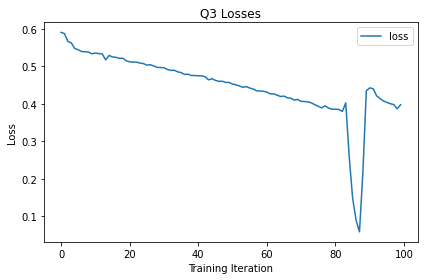

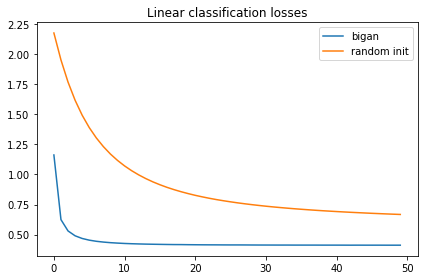

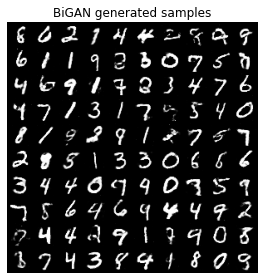

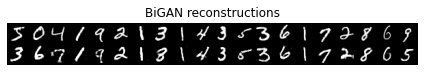

BiGAN final linear classification loss: 0.4125858883677261
Random encoder linear classification loss: 0.6678698149952553
CPU times: user 41min 30s, sys: 1min 30s, total: 43min
Wall time: 43min 43s


In [ ]:
%%time

q3_save_results(q3)

# Question 4 (Bonus): CycleGAN [20pt]
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

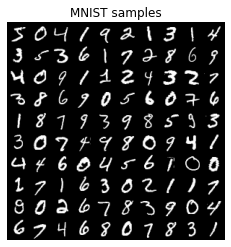

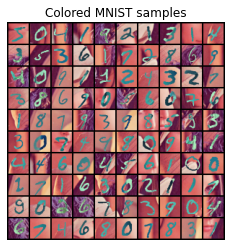

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def q4(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

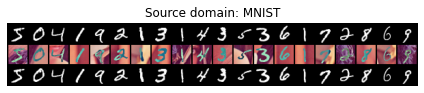

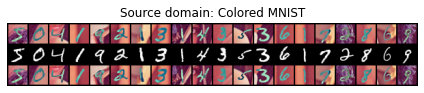

In [ ]:
q4_save_results(q4)